<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0813.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
from keras.utils import to_categorical
import datetime
import random

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_500_acc(y_true, y_pred):
    delta = 500
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_1000_acc(y_true, y_pred):
    delta = 1000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_10000_acc(y_true, y_pred):
    delta = 10000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_5perc_acc(y_true, y_pred):
    delta = 0.05
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))

def soft_10perc_acc(y_true, y_pred):
    delta = 0.10
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))


def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values
            
class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))

periodic_logger_10 = PeriodicLogger(10) 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

     |████████████████████████████████| 276kB 4.5MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=c8e94d91bf8053e88927860470b6835b083d5a95df6f6fedf5061fe47f830794
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


## 성립 실험을 위한 시뮬레이션 데이터 생성

극단적인 power law 형태의 distribution을 시뮬레이션 한다.


<img src='https://miro.medium.com/max/2704/1*FLyS1quRikOyL_-dCA73yg.png' width='500'/>


In [2]:
def nafyc_func(row):
    code,real_yy,rate = row['CODE'],row['REAL_YY'],row['COM_RATE']
    return real_yy * rate + 99

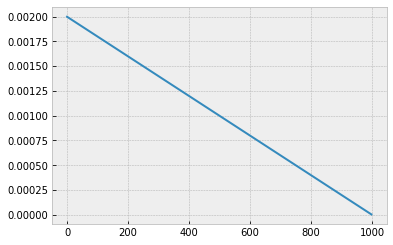

In [14]:
# random choice의 provability distribution
p = [1000-i for i in range(1000-1)]
p = p/np.sum(p)
plt.plot(p)

In [164]:
def create_samples(n_samples):
    rate_table = {}
    samples = []
    for i in range(1000,2520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,500))
      for j in range(count):
        real_yy = int((np.random.choice(range(1,1000),p=p)/10)**6/100000 + 100)
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]
        samples.append([code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CODE','REAL_YY','COM_RATE'])

In [220]:
dataset = create_samples(n_samples=100)
dataset['NAFYC'] = dataset.apply(nafyc_func, axis=1)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,192,0.12,122.04
1,1000,20115,0.12,2512.80
2,1000,103,0.12,111.36
3,1000,324,0.12,137.88
4,1000,684,0.12,181.08
...,...,...,...,...
392803,2519,500,0.34,269.00
392804,2519,233,0.34,178.22
392805,2519,69744,0.34,23811.96
392806,2519,100,0.34,133.00


## 성립 데이터 EDA

In [221]:
dataset = dataset.astype({"CODE": object})
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CODE,object,392808.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1520.0,2274.0,499.0
REAL_YY,int64,392808.0,0,357117.767994,987163.517993,100.00,157.00,6298.00,156350.00,9940249.00,NaN,NaN,NaN
COM_RATE,float64,392808.0,0,0.489699,0.292374,0.01,0.22,0.48,0.75,0.99,NaN,NaN,NaN
NAFYC,float64,392808.0,0,175531.791082,573632.147138,100.00,187.00,2308.74,57571.37,9606885.75,NaN,NaN,NaN


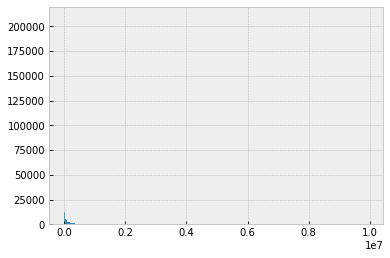

In [224]:
# 극단적인 power law 형태 확인  
dataset['REAL_YY'].hist(bins=1000)

## 데이터 전처리

In [228]:
def data_preprocess(ds1):
  # zscore norm
  ds = ds1.copy()

  dst = ds[['REAL_YY','COM_RATE']]

  _mean = dst.mean(axis=0)
  _std = dst.std(axis=0)

  dst = dst - _mean
  dst /= _std

  ds.update(dst)

  # code mapping
  code_mapping = EmbeddingMapping(ds['CODE'])
  ds = ds.assign(code_mapping=ds['CODE'].apply(code_mapping.get_mapping))

  # trainset과 validationset 나누고... 기타 정리

  X_train_org, X_val_org, Y_train, Y_val = train_test_split(ds[['REAL_YY','code_mapping']],
      ds['NAFYC'], test_size=0.1, random_state=0)

  # 학습 대상 변수만 선택
  X_train_continuous = X_train_org[['REAL_YY']]
  X_train_categorical = X_train_org[['code_mapping']]

  X_val_continuous  = X_val_org[['REAL_YY']]
  X_val_categorical = X_val_org[['code_mapping']]
  return X_train_continuous,X_train_categorical,X_val_continuous,X_val_categorical,Y_train, Y_val

X_train_continuous,X_train_categorical,X_val_continuous,X_val_categorical,Y_train, Y_val = data_preprocess(dataset)

## Network 구성

In [239]:

def model_build(X_train_continuous,X_train_categorical): 
    # Define the embedding input
    code_input = Input(shape=(1,), dtype='int32') 
    output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
    code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
    code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

    # Define the continuous variables input (just like before)
    continuous_input = Input(shape=(X_train_continuous.shape[1], ))

    # Concatenate continuous and embeddings inputs
    all_input = keras.layers.concatenate([continuous_input, code_embedings])
    print(all_input)

    # Define the model
    dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
    dense2 = Dense(5, activation='relu')(dense1)
    predictions = Dense(1)(dense2)

    # Note using the input object 'area_input' not 'area_embeddings'
    model = Model(inputs=[continuous_input, code_input], outputs=predictions)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10perc_acc,soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
    model.summary()
    return model

model = model_build(X_train_continuous,X_train_categorical)

Tensor("concatenate_38/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_92"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_77 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 1, 64)        97344       input_77[0][0]                   
__________________________________________________________________________________________________
input_78 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_38 (Reshape)            (None, 64)           0           embedding_38[0][0]               
___________________

## 학습

Epoch: 10 - {'loss': 292677568.0, 'soft_5perc_acc': 0.14664997160434723, 'soft_10perc_acc': 0.20252421498298645, 'soft_500_acc': 0.20614643394947052, 'soft_1000_acc': 0.2592160403728485, 'soft_10000_acc': 0.6776571273803711, 'r2': 0.9991226196289062, 'val_loss': 327393728.0, 'val_soft_5perc_acc': 0.17004510760307312, 'val_soft_10perc_acc': 0.22179393470287323, 'val_soft_500_acc': 0.2105632871389389, 'val_soft_1000_acc': 0.2873515784740448, 'val_soft_10000_acc': 0.7869548797607422, 'val_r2': 0.9989663362503052}
Epoch: 20 - {'loss': 21856692.0, 'soft_5perc_acc': 0.2821284532546997, 'soft_10perc_acc': 0.3463800549507141, 'soft_500_acc': 0.24739646911621094, 'soft_1000_acc': 0.38548365235328674, 'soft_10000_acc': 0.9694020748138428, 'r2': 0.999933123588562, 'val_loss': 165945760.0, 'val_soft_5perc_acc': 0.25709837675094604, 'val_soft_10perc_acc': 0.32137787342071533, 'val_soft_500_acc': 0.22181348502635956, 'val_soft_1000_acc': 0.3091939091682434, 'val_soft_10000_acc': 0.9573154449462891, 

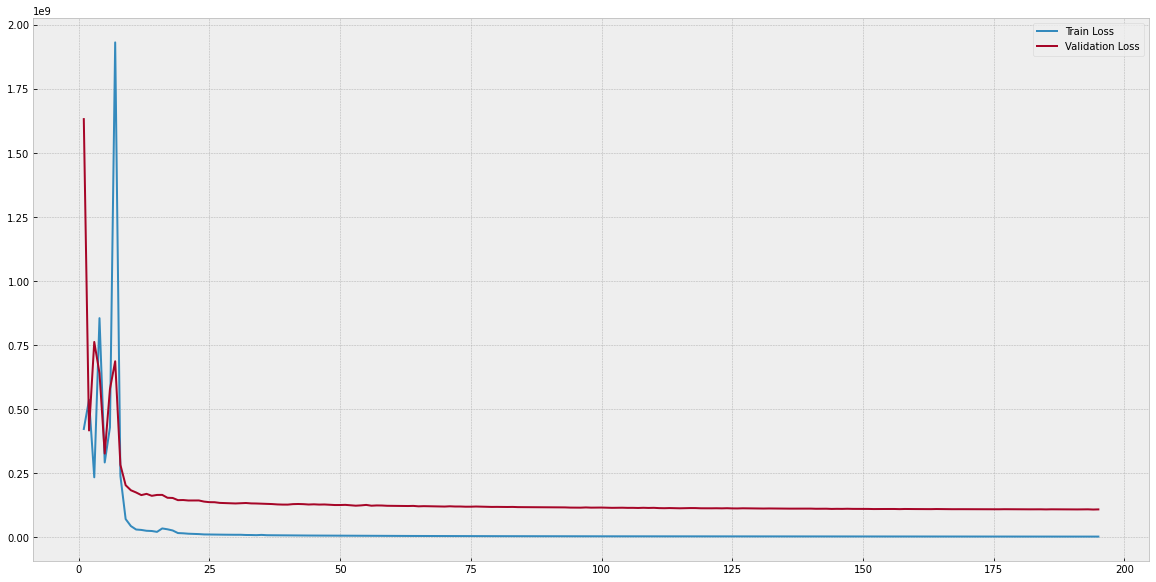

In [240]:
def train_model(model,X_train_continuous, X_train_categorical,X_val_continuous, X_val_categorical,Y_train, Y_val, epochs = 200):
  # Note continuous and categorical columns are inserted in the same order as defined in all_inputs
  history = model.fit([X_train_continuous, X_train_categorical], Y_train, 
            epochs=epochs, batch_size=10000, 
            callbacks=[periodic_logger_10], verbose=0,
            validation_data=([X_val_continuous, X_val_categorical], Y_val))
  # Plot the train/validation loss values
  plt.figure(figsize=(20,10))
  _loss = history.history['loss'][5:]
  _val_loss = history.history['val_loss'][5:]

  train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
  val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

  _ = plt.legend(handles=[train_loss_plot, val_loss_plot])
  return model

train_model(model,X_train_continuous, X_train_categorical,X_val_continuous, X_val_categorical,Y_train,Y_val, epochs = 200)

## 전략의 변경

상대오차 (5%, 10%)는 50%를 넘기지 못하면서, 절대오차 (10000원)은 99% 이상을 보이는 현상은 NAFYC가 극단적인 power law distribution을 갖기 떄문이다.
따라서, 전체 데이터를 한번에 학습하는 것이 아니라 구간별로 나누어 학습하는 방법으로 전략을 변경한다.
이를 통해, 각 구간에서 극단적인 power law 분포를 회피하도록 한다.

## 3개 구간별 학습

10만원 이상, 1만원에서 10만원 사이, 1만원이하 3개 구간으로 나눈다.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4670b6b00>,
      dtype=object)

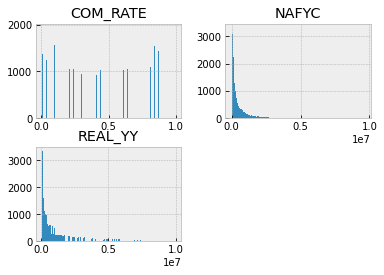

In [242]:
# 10만원 이상이 되는 놈들만 선택해서 한다.
ds_e5 = dataset[dataset['REAL_YY'] > 100000]
ds_e5.hist(bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb452120390>,
      dtype=object)

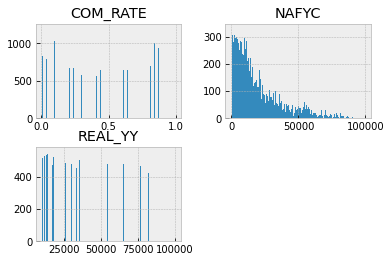

In [286]:
# 1만원에서 10만원 이하 놈들만 선택해서 한다.
ds_e4 = dataset[(dataset['REAL_YY'] > 10000) & (dataset['REAL_YY'] <= 100000)]
ds_e4.hist(bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb440c98748>,
      dtype=object)

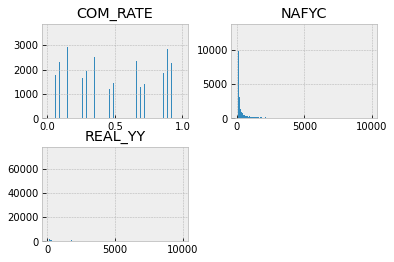

In [301]:
# 1만원이하 놈들만 선택해서 한다.
ds_e1 = dataset[dataset['REAL_YY'] <= 10000]
ds_e1.hist(bins=1000)

In [245]:
print('1구간(10만이상) 비율:',ds_e5.shape[0]/dataset.shape[0])
print('2구간( 1만이상) 비율:',ds_e4.shape[0]/dataset.shape[0])
print('3구간( 1만이하) 비율:',ds_e1.shape[0]/dataset.shape[0])

1구간(10만이상) 비율: 0.2859132196900267
2구간( 1만이상) 비율: 0.18152888943198714
3구간( 1만이하) 비율: 0.5325578908779862


Tensor("concatenate_51/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_118"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_103 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 1, 64)        97344       input_103[0][0]                  
__________________________________________________________________________________________________
input_104 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_51 (Reshape)            (None, 64)           0           embedding_51[0][0]               
__________________

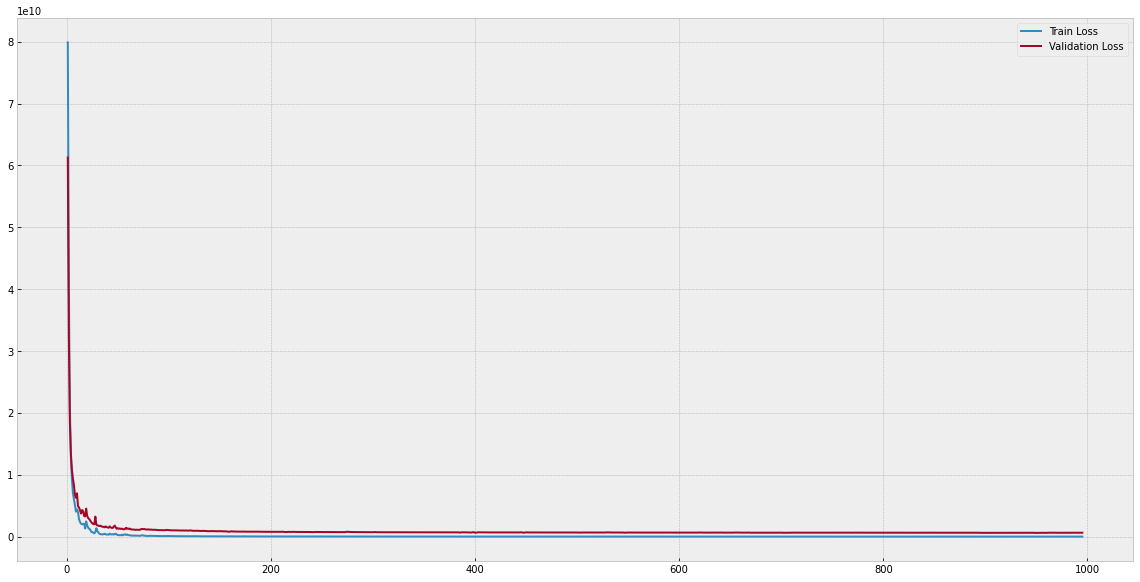

In [298]:
# 1구간 (10만원 이상)의 학습
X_train_continuous,X_train_categorical,X_val_continuous_e5,X_val_categorical_e5,Y_train, Y_val_e5 = data_preprocess(ds_e5)
model_e5 = model_build(X_train_continuous,X_train_categorical)
model_build_e5 = train_model(model_e5,X_train_continuous,X_train_categorical,X_val_continuous_e5,X_val_categorical_e5,Y_train, Y_val_e5,epochs = 1000)

Tensor("concatenate_52/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_120"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_105 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, 1, 64)        97216       input_105[0][0]                  
__________________________________________________________________________________________________
input_106 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_52 (Reshape)            (None, 64)           0           embedding_52[0][0]               
__________________

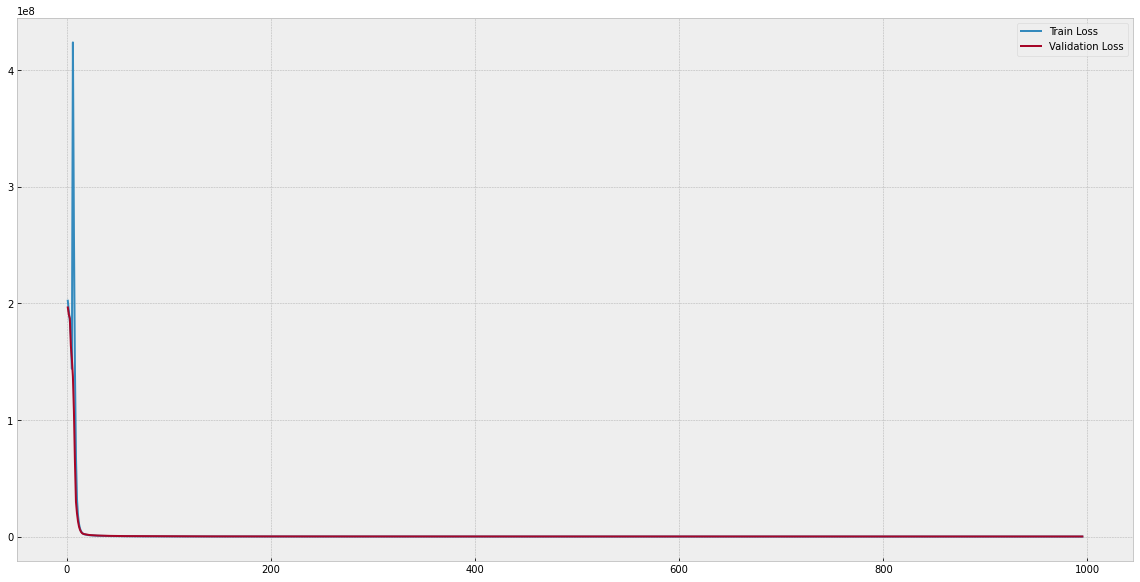

In [299]:
# 2구간 ( 1만원 이상)의 학습
X_train_continuous,X_train_categorical,X_val_continuous_e4,X_val_categorical_e4,Y_train, Y_val_e4 = data_preprocess(ds_e4)
model_e4 = model_build(X_train_continuous,X_train_categorical)
model_build_e4 = train_model(model_e4,X_train_continuous,X_train_categorical,X_val_continuous_e4,X_val_categorical_e4,Y_train, Y_val_e4,epochs = 1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Tensor("concatenate_54/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_124"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_109 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_54 (Embedding)        (None, 1, 64)        97344       input_109[0][0]                  
__________________________________________________________________________________________________
input_110 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_54 (Reshape)            (None, 64)           0           embedding_54[0][0]               
__________________

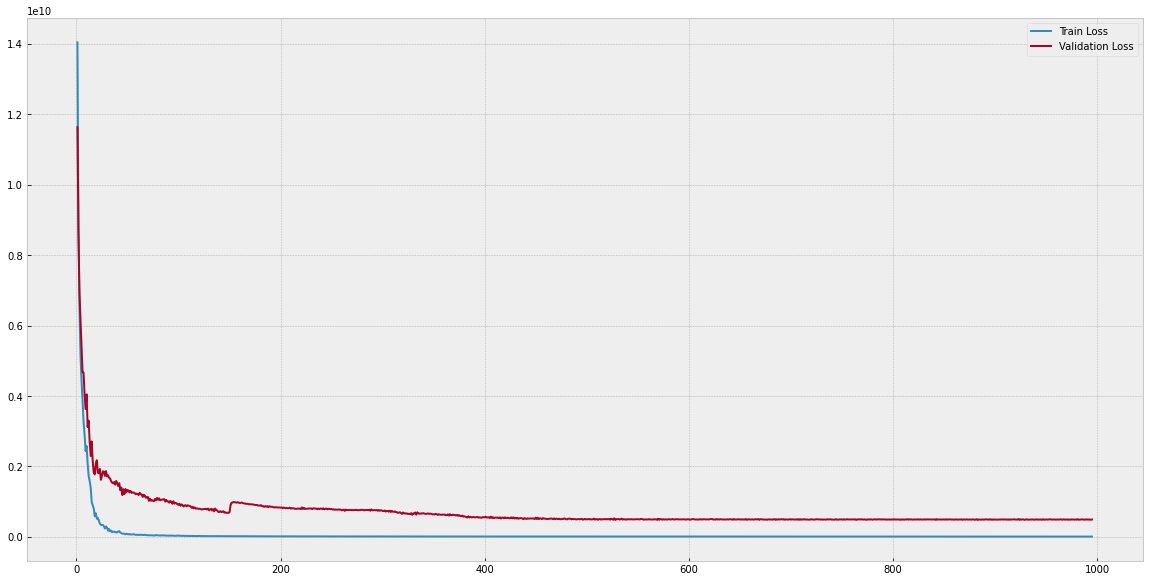

In [302]:
# 3구간 ( 1만원 이하)의 학습

# 전처리 추가
ds_e1['NAFYC'] = ds_e1['NAFYC'] * 1000

X_train_continuous,X_train_categorical,X_val_continuous_e1,X_val_categorical_e1,Y_train, Y_val_e1 = data_preprocess(ds_e1)
model_e1 = model_build(X_train_continuous,X_train_categorical)
model_build_e1 = train_model(model_e1,X_train_continuous,X_train_categorical,X_val_continuous_e1,X_val_categorical_e1,Y_train, Y_val_e1,epochs = 1000)

## 3개 구간 전체적인 Evaluation

In [303]:
# 1구간 
df1 = pd.DataFrame(Y_val_e5,columns=['NAFYC'])
print ("1구간 평균 NAFYC: %d" % df1['NAFYC'].mean())
# Add a column for the model's predicted values
df1['pred'] = model_build_e5.predict([X_val_continuous_e5, X_val_categorical_e5])
# Calculate the difference between the predicted and the actual price
df1['diff'] = df1['pred'] - df1['NAFYC']
# Calculate the absolute difference between the predicted and the actual price
df1['abs_diff'] = np.abs(df1['diff'])
# Calculate the percentage of the difference from the actual price
df1['%diff'] = 100 * (df1['diff'] / df1['NAFYC'])
# Calculate the absolute percentage difference from the actual price
df1['abs_%diff'] = np.abs(df1['%diff'])
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df1['diff'].mean(), df1['diff'].std()
print("1구간 오차평균 ({mean}) 표준편차 {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))
print("5% 오차내 정확도 ",1- df1[df1['abs_%diff'] > 5]['abs_%diff'].count()/df1['abs_%diff'].count())

1구간 평균 NAFYC: 597697
1구간 오차평균 (1233.26) 표준편차 25242.47.
5% 오차내 정확도  0.9400765737690322


In [304]:
# 2구간 
df2 = pd.DataFrame(Y_val_e4,columns=['NAFYC'])
print ("2구간 평균 NAFYC: %d" % df2['NAFYC'].mean())
# Add a column for the model's predicted values
df2['pred'] = model_build_e4.predict([X_val_continuous_e4, X_val_categorical_e4])
# Calculate the difference between the predicted and the actual price
df2['diff'] = df2['pred'] - df2['NAFYC']
# Calculate the absolute difference between the predicted and the actual price
df2['abs_diff'] = np.abs(df2['diff'])
# Calculate the percentage of the difference from the actual price
df2['%diff'] = 100 * (df2['diff'] / df2['NAFYC'])
# Calculate the absolute percentage difference from the actual price
df2['abs_%diff'] = np.abs(df2['%diff'])
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df2['diff'].mean(), df2['diff'].std()
print("2구간 오차평균 ({mean}) 표준편차 {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))
print("5% 오차내 정확도 ",1- df2[df2['abs_%diff'] > 5]['abs_%diff'].count()/df2['abs_%diff'].count())

2구간 평균 NAFYC: 19687
2구간 오차평균 (8.97) 표준편차 342.43.
5% 오차내 정확도  0.9305847707193942


In [305]:
# 3구간 
df3 = pd.DataFrame(Y_val_e1,columns=['NAFYC'])
#학습을 위해 * 1000을 했으므로 이를 다시 보정
df3['NAFYC']=df3['NAFYC']/1000
print ("3구간 평균 NAFYC: %d" % df3['NAFYC'].mean())
# Add a column for the model's predicted values
df3['pred'] = model_build_e1.predict([X_val_continuous_e1, X_val_categorical_e1])
#학습을 위해 * 1000을 했으므로 이를 다시 보정
df3['pred']=df3['pred']/1000
# Calculate the difference between the predicted and the actual price
df3['diff'] = df3['pred'] - df3['NAFYC']
# Calculate the absolute difference between the predicted and the actual price
df3['abs_diff'] = np.abs(df3['diff'])
# Calculate the percentage of the difference from the actual price
df3['%diff'] = 100 * (df3['diff'] / df3['NAFYC'])
# Calculate the absolute percentage difference from the actual price
df3['abs_%diff'] = np.abs(df3['%diff'])
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df3['diff'].mean(), df3['diff'].std()
print("3구간 오차평균 ({mean}) 표준편차 {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))
print("5% 오차내 정확도 ",1- df3[df3['abs_%diff'] > 5]['abs_%diff'].count()/df3['abs_%diff'].count())

3구간 평균 NAFYC: 741
3구간 오차평균 (-0.14) 표준편차 22.23.
5% 오차내 정확도  0.9983269598470363


In [307]:
df = pd.concat([df1,df2,df3])
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("전체 구간 오차평균 ({mean}) 표준편차 {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))
print("1% 오차내 정확도 ",1- df[df['abs_%diff'] > 1]['abs_%diff'].count()/df['abs_%diff'].count())
print("5% 오차내 정확도 ",1- df[df['abs_%diff'] > 5]['abs_%diff'].count()/df['abs_%diff'].count())
print("10% 오차내 정확도 ",1- df[df['abs_%diff'] > 10]['abs_%diff'].count()/df['abs_%diff'].count())


전체 구간 오차평균 (354.15) 표준편차 13509.04.
1% 오차내 정확도  0.8537498090728578
5% 오차내 정확도  0.9693752863907134
10% 오차내 정확도  0.9869914973779339


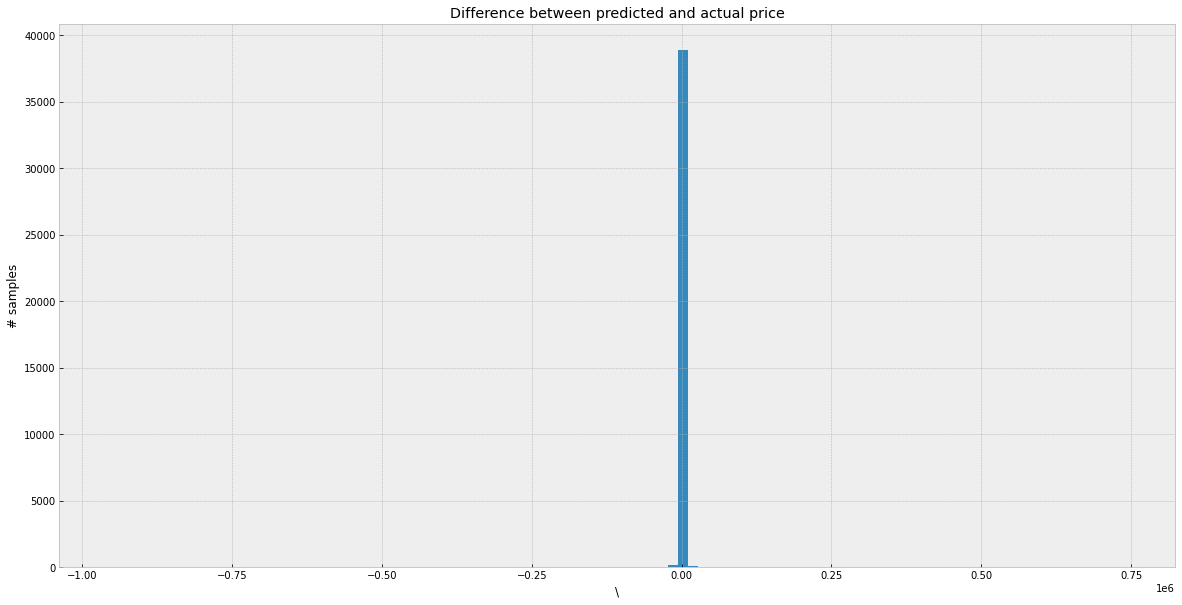

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC
376848,2.085010e+06,-953725.5000,953725.5000,-31.385609,31.385609,2451,3798295,0.80,3038735.00
196019,4.693378e+06,739021.0800,739021.0800,18.688778,18.688778,1751,9414901,0.42,3954357.42
252751,2.911225e+06,737896.0600,737896.0600,33.952341,33.952341,1964,5174357,0.42,2173328.94
294146,1.217615e+06,714627.3800,714627.3800,142.076535,142.076535,2113,8381477,0.06,502987.62
268147,9.563159e+05,-697432.2350,697432.2350,-42.172821,42.172821,2015,2468133,0.67,1653748.11
305152,5.388337e+06,692309.4000,692309.4000,14.742447,14.742447,2157,8538052,0.55,4696027.60
166322,1.274116e+06,638579.0750,638579.0750,100.478615,100.478615,1635,9077690,0.07,635537.30
159513,7.922981e+05,602756.9625,602756.9625,318.008581,318.008581,1605,9472105,0.02,189541.10
1967,2.224658e+06,599392.3000,599392.3000,36.879639,36.879639,1009,8125836,0.20,1625266.20
205998,3.066184e+06,497112.8300,497112.8300,19.349909,19.349909,1789,8858523,0.29,2569070.67


In [308]:
# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [200]:
ds_e1

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,2.396714,-0.198817,2984080.0
1,1000,-0.542445,-0.198817,152240.0
2,1000,-0.034623,-0.198817,641520.0
3,1000,-0.552035,-0.198817,143000.0
6,1000,1.256854,-0.198817,1885840.0
...,...,...,...,...
397571,2519,3.052042,0.491224,5213880.0
397572,2519,-0.020009,0.491224,908600.0
397573,2519,-0.160665,0.491224,711480.0
397574,2519,-0.483990,0.491224,258360.0


In [ ]:
dataset2 = dataset[dataset['NAFYC'] > 100000]
dataset2 = dataset2.astype({"CODE": object})

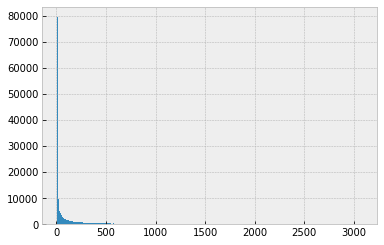

In [116]:
dataset['NAFYC2'] = np.sqrt(dataset['NAFYC'])
dataset['NAFYC2'].hist(bins=1000)

In [117]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','code_mapping']],
    dataset['NAFYC2'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY']]
X_val_categorical = X_val_org[['code_mapping']]

In [118]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)
# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)
# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10perc_acc,soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
model.summary()

Tensor("concatenate_23/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_62"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 1, 64)        97344       input_47[0][0]                   
__________________________________________________________________________________________________
input_48 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_23 (Reshape)            (None, 64)           0           embedding_23[0][0]               
___________________

In [119]:
epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Epoch: 10 - {'loss': 136349.9375, 'soft_5perc_acc': 0.01614723913371563, 'soft_10perc_acc': 0.032318368554115295, 'soft_500_acc': 0.9000565409660339, 'soft_1000_acc': 0.96232670545578, 'soft_10000_acc': 1.0, 'r2': -0.021287424489855766, 'val_loss': 133719.984375, 'val_soft_5perc_acc': 0.01593262515962124, 'val_soft_10perc_acc': 0.03276851400732994, 'val_soft_500_acc': 0.901864767074585, 'val_soft_1000_acc': 0.9642904996871948, 'val_soft_10000_acc': 1.0, 'val_r2': -0.01698365807533264}
Epoch: 20 - {'loss': 133592.0, 'soft_5perc_acc': 0.016541684046387672, 'soft_10perc_acc': 0.03280170261859894, 'soft_500_acc': 0.9083459377288818, 'soft_1000_acc': 0.9656217098236084, 'soft_10000_acc': 1.0, 'r2': -0.0007780194282531738, 'val_loss': 131532.34375, 'val_soft_5perc_acc': 0.016748927533626556, 'val_soft_10perc_acc': 0.03398662805557251, 'val_soft_500_acc': 0.9101002216339111, 'val_soft_1000_acc': 0.967465877532959, 'val_soft_10000_acc': 1.0, 'val_r2': -0.000356137752532959}
Epoch: 30 - {'loss'

## Non-linearity 대응을 위한 polynomial Regression 적용
https://medium.com/analytics-vidhya/polynomial-regression-with-keras-ef1797b39b88

In [120]:
from sklearn.preprocessing import PolynomialFeatures

# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

n = 3
trX_expanded = np.expand_dims(X_train_continuous, axis=1)
poly = PolynomialFeatures(n)
X_train_continuous = poly.fit_transform(X_train_continuous)
X_val_continuous = poly.fit_transform(X_val_continuous)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10perc_acc,soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
model.summary()

epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate_24/concat:0", shape=(None, 68), dtype=float32)
Model: "functional_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 1, 64)        97344       input_49[0][0]                   
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
reshape_24 (Reshape)            (None, 64)           0           embedding_24[0][0]               
___________________

## 학습 결과 확인

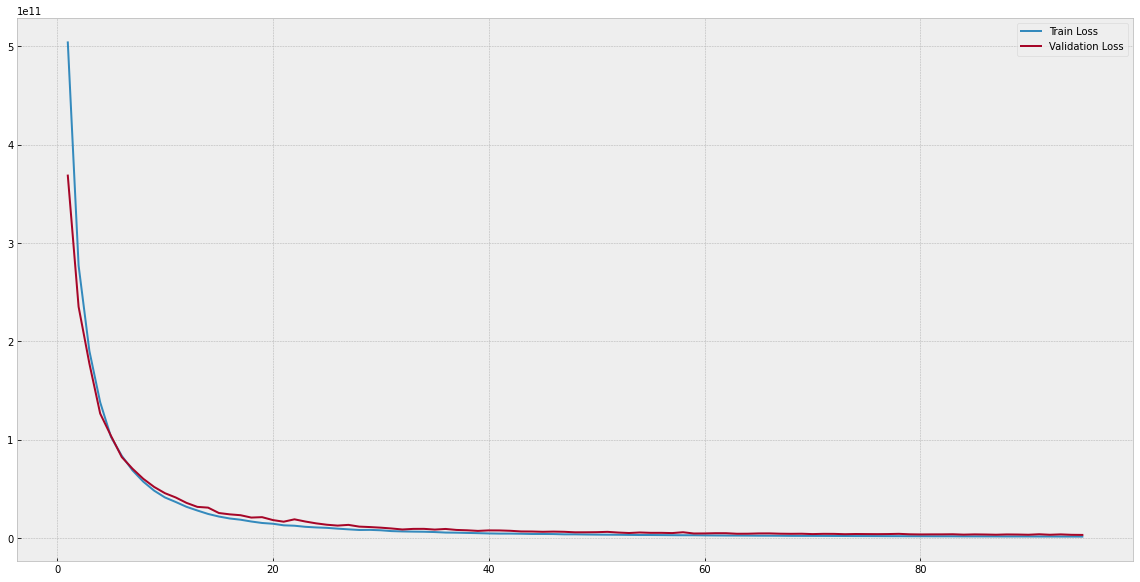

This is the average value we are trying to predict: 12604089
The mean is very close to 0 (3162.25) with std. 58018.97.


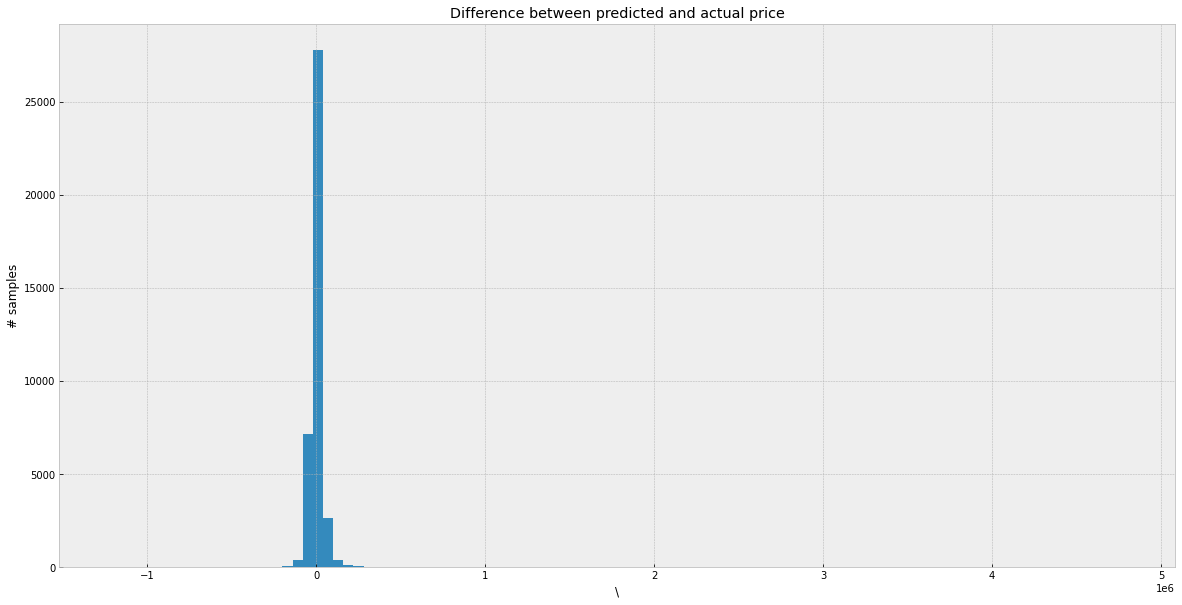

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
81592,40496612.00,4784117.00,4784117.00,13.396199,13.396199,1307,2.045077,0.028820,35712495.0,308
171327,44001340.00,2731540.00,2731540.00,6.618738,6.618738,1666,2.469352,0.063892,41269800.0,667
383166,2657801.75,2553081.75,2553081.75,2438.007783,2438.007783,2499,-1.130250,1.326476,104720.0,1500
44561,75698904.00,1737072.00,1737072.00,2.348606,2.348606,1166,3.284843,0.905614,73961832.0,167
383165,3956649.00,1575545.00,1575545.00,66.168676,66.168676,2499,-1.012749,1.326476,2381104.0,1500
338627,11480491.00,1484274.00,1484274.00,14.848357,14.848357,2320,2.992159,-1.374051,9996217.0,1321
81594,6817967.00,-1219888.00,1219888.00,-15.176785,15.176785,1307,-0.419764,0.028820,8037855.0,308
329701,86113016.00,1189880.00,1189880.00,1.401126,1.401126,2287,3.298224,1.291404,84923136.0,1288
44006,16511478.00,1176422.00,1176422.00,7.671456,7.671456,1164,3.217884,-1.198692,15335056.0,165
228468,90827096.00,-1173109.00,1173109.00,-1.275116,1.275116,1885,3.085494,1.712265,92000205.0,886


In [ ]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [ ]:
dataset[dataset['code_mapping']==3]

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
233,1002,-0.967499,0.730255,2628420.0,3
234,1002,2.657077,0.730255,59283438.0,3
235,1002,-0.113090,0.730255,15983520.0,3
236,1002,0.302078,0.730255,22472920.0,3
237,1002,-0.424738,0.730255,11112210.0,3
...,...,...,...,...,...
570,1002,-0.084873,0.730255,16424572.0,3
571,1002,-0.243454,0.730255,13945820.0,3
572,1002,-0.457760,0.730255,10596040.0,3
573,1002,-0.299370,0.730255,13071810.0,3


In [ ]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
0,1000,-0.906546,-0.462185,1866243.0,1
1,1000,-0.053195,-0.462185,8817322.0,1
2,1000,1.183714,-0.462185,18892718.0,1
3,1000,0.561807,-0.462185,13826900.0,1
4,1000,0.437321,-0.462185,12812878.0,1
...,...,...,...,...,...
388065,2519,-0.791257,-1.268835,1061480.0,1520
388066,2519,0.062789,-1.268835,3693760.0,1520
388067,2519,0.966346,-1.268835,6478640.0,1520
388068,2519,2.110623,-1.268835,10005450.0,1520


## 성립 데이터에 대한 파생변수 추가 실험
# NAFYC 산출 관계식에 의한 파생변수 추가 

In [ ]:
dataset['ft1'] = dataset['REAL_YY']* dataset['COM_RATE']

In [ ]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
0,1000,-0.497537,-1.084695,69600.42,1,0.539676
1,1000,-0.482363,-1.084695,686612.12,1,0.523217
2,1000,-0.499242,-1.084695,265.24,1,0.541526
3,1000,-0.488875,-1.084695,421815.20,1,0.530280
4,1000,-0.496209,-1.084695,123621.41,1,0.538235
...,...,...,...,...,...,...
383709,2519,-0.499175,0.644901,10926.15,1520,-0.321918
383710,2519,-0.487524,0.644901,1731404.58,1520,-0.314405
383711,2519,-0.108952,0.644901,57634320.69,1520,-0.070263
383712,2519,-0.099061,0.644901,59094883.71,1520,-0.063885


In [ ]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','ft1','code_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY','ft1']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY','ft1']]
X_val_categorical = X_val_org[['code_mapping']]


In [ ]:
Y_train

225181    1.499210e+06
105434    9.798358e+07
39305     5.160489e+06
151677    6.741836e+08
86507     6.528000e+01
              ...     
359783    1.756332e+08
358083    3.491232e+04
152315    5.441101e+06
117952    7.804143e+05
305711    3.964330e+06
Name: NAFYC, Length: 345342, dtype: float64

## 네크워크 구성 (기존과 동일) 및 학습

In [ ]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10perc_acc,soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
model.summary()

epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate_5/concat:0", shape=(None, 66), dtype=float32)
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 64)        97344       input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 64)           0           embedding_5[0][0]                
____________________

## poly regression 적용

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

n = 3
trX_expanded = np.expand_dims(X_train_continuous, axis=1)
poly = PolynomialFeatures(n)
X_train_continuous = poly.fit_transform(X_train_continuous)
X_val_continuous = poly.fit_transform(X_val_continuous)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10perc_acc,soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
model.summary()

epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate_6/concat:0", shape=(None, 74), dtype=float32)
Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 64)        97344       input_13[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 64)           0           embedding_6[0][0]                
____________________

## 학습 결과 확인

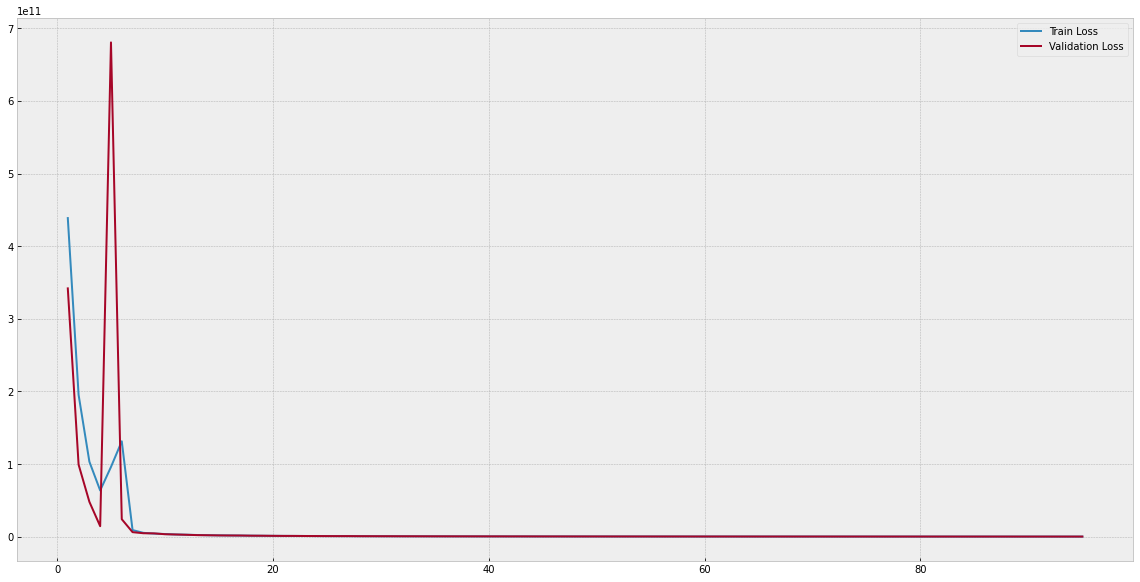

In [ ]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][5:]
_val_loss = history.history['val_loss'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

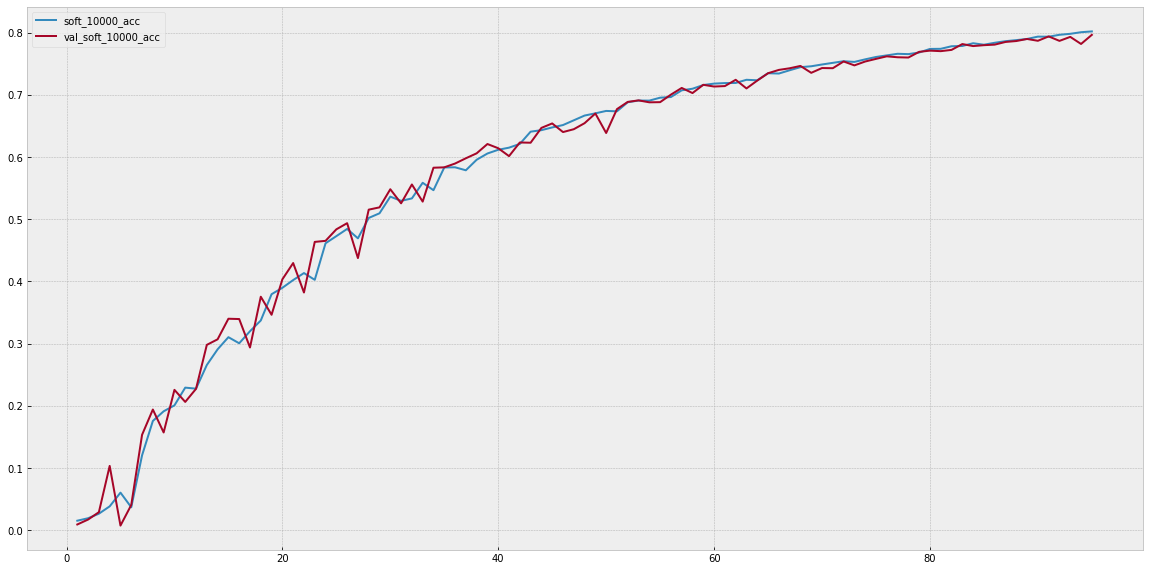

In [ ]:
plt.figure(figsize=(20,10))
_loss = history.history['soft_10000_acc'][5:]
_val_loss = history.history['val_soft_10000_acc'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='soft_10000_acc')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='val_soft_10000_acc')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 12739733
The mean is very close to 0 (683.15) with std. 14556.2.


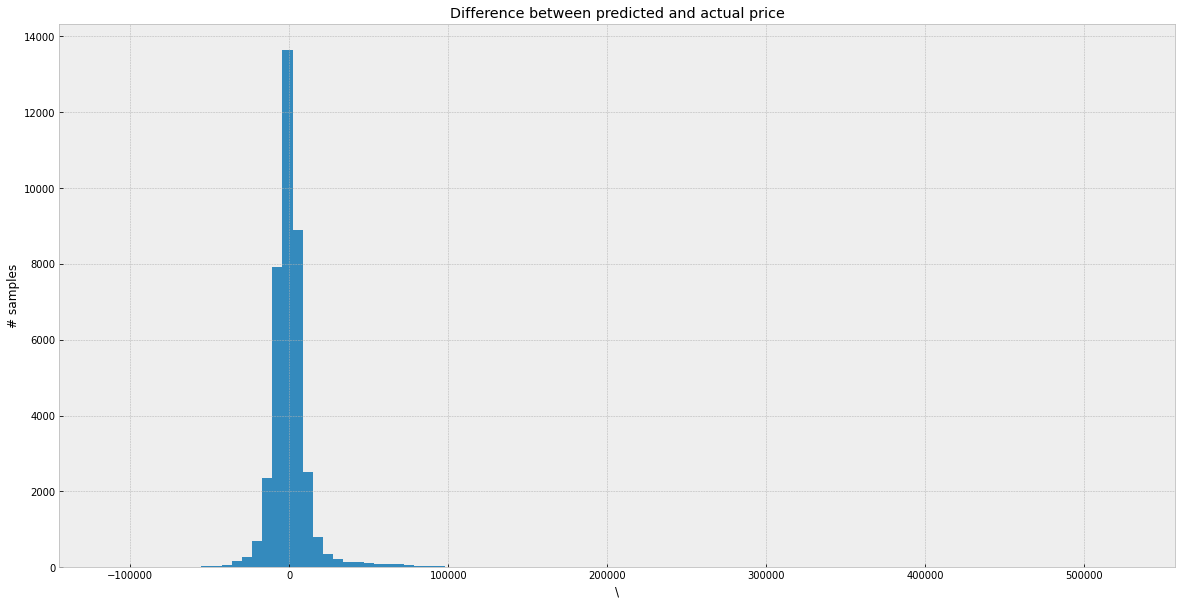

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
332164,5.549403e+05,525180.312500,525180.312500,1764.718792,1764.718792,2302,-1.131859,-0.690566,29760.0,1303,0.781623
318939,8.771789e+05,275949.875000,275949.875000,45.897632,45.897632,2255,1.590676,-1.736187,601229.0,1256,-2.761710
169370,9.636630e+07,227404.000000,227404.000000,0.236537,0.236537,1655,3.268234,1.679508,96138900.0,656,5.489024
3258,2.898155e+05,223255.531250,223255.531250,335.419969,335.419969,1012,-1.132439,1.017281,66560.0,13,-1.152009
53861,2.292626e+07,201524.000000,201524.000000,0.886805,0.886805,1195,3.345030,-0.969398,22724736.0,196,-3.242665
118527,2.645377e+05,200853.718750,200853.718750,315.391179,315.391179,1464,-1.132893,1.261259,63684.0,465,-1.428872
98500,2.084155e+05,196015.468750,196015.468750,1580.769909,1580.769909,1384,-1.133963,-0.899690,12400.0,385,1.020215
332166,1.644945e+07,195898.000000,195898.000000,1.205263,1.205263,2302,1.241799,-0.690566,16253548.0,1303,-0.857544
337266,2.254195e+05,193419.546875,193419.546875,604.436084,604.436084,2325,-1.134399,1.017281,32000.0,1326,-1.154002
94816,3.618914e+07,186286.000000,186286.000000,0.517420,0.517420,1370,3.277078,-0.481442,36002850.0,371,-1.577722


In [ ]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

## polynomial + Support vector Regression

https://keras.io/examples/keras_recipes/quasi_svm/

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.layers.experimental import RandomFourierFeatures

# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

######################### polynomial
n = 3
trX_expanded = np.expand_dims(X_train_continuous, axis=1)
poly = PolynomialFeatures(n)
X_train_continuous = poly.fit_transform(X_train_continuous)
X_val_continuous = poly.fit_transform(X_val_continuous)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))
######################## Support vector 
#svr_layer = RandomFourierFeatures(output_dim=X_train_continuous.shape[1]*4, scale=10.0, kernel_initializer="gaussian")(continuous_input)
# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu', kernel_initializer="uniform")(all_input)
dense2 = Dense(3, activation='relu', kernel_initializer="uniform")(dense1)
predictions = Dense(1, kernel_initializer="uniform")(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10perc_acc,soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
#model.compile(loss=keras.losses.hinge, optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10perc_acc,soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
model.summary()

epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=5000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate_29/concat:0", shape=(None, 74), dtype=float32)
Model: "functional_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 1, 64)        97344       input_61[0][0]                   
__________________________________________________________________________________________________
input_62 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_30 (Reshape)            (None, 64)           0           embedding_30[0][0]               
___________________

## lime에 의한 XAI 싷험

In [ ]:
train_ds = pd.concat([X_train_continuous,X_train_categorical], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical], axis=1)

# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=Y_train,
    feature_names=train_ds.columns,
    class_names= ['NAFYC'],
    mode="regression"
)

In [ ]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'])
effect_result_table['Effect'] = effect_result_table['Effect']/10000
effect_result_table.plot(x='Feature',y='Effect', figsize=(8, 10),kind='barh')
plt.show()
effect_result_table

## 실효/해약 등 Event 시뮬레이션 데이터 생성

In [ ]:
contract_change_rules = {
    '성립': 0,
    '실효': -0.4,
    '해약': -0.8,
    '철회': -0.5,
    '변경': -0.1
}

def create_samples2():
    rate_table = {}
    samples = []
    start_date = datetime.date(2015, 1, 1)
    end_date = datetime.date(2020, 8, 8)

    for i in range(1000,1520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,250))
      for j in range(count):
        cntr_no = str(random.choice(range(100000,500000))) + ':' + str(random.choice(range(100000,500000)))
        real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) # * 100
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]

        div = '성립'
        minus_rate = 0

        # 계약일 생성
        time_between_dates = end_date - start_date
        days_between_dates = time_between_dates.days
        random_number_of_days = random.randrange(days_between_dates)
        contract_date = start_date + datetime.timedelta(days=random_number_of_days)
        event_date = contract_date
        # 계약 총개월수 생성 
        contract_months = np.random.choice(range(12,12*30))
        event_num = 0
        samples.append([cntr_no,div,event_num,minus_rate,contract_date,contract_months,event_date,code,real_yy,rate])
        for changes in range(19):
          event_num += 1
          div = random.choice(['실효','해약','철회','변경'])
          # Event 발생일 생성 
          time_between_dates = end_date - event_date
          days_between_dates = time_between_dates.days
          random_number_of_days = random.randrange(days_between_dates)
          event_date = event_date + datetime.timedelta(days=random_number_of_days)
          if div=='변경':
            contract_date = event_date
            code = np.random.choice(range(1000,1520))
            real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) # * 100
            contract_months = np.random.choice(range(12,12*30))       
            if code not in rate_table:
              rate = np.random.choice(range(1,100)) / 100
              rate_table[code] = rate
            else:
              rate = rate_table[code]
          elif div=='해약':
            samples.append([cntr_no,div,event_num,contract_change_rules[div],contract_date,contract_months,event_date,code,real_yy,rate])
            break

          samples.append([cntr_no,div,event_num,contract_change_rules[div],contract_date,contract_months,event_date,code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CONTRACT_ID','DIV','EVENT_NUM','MINUS_RATE','CONTRACT_DATE','CONTRACT_MONTHS','EVENT_DATE','CODE','REAL_YY','COM_RATE'])

In [ ]:
dataset2 = create_samples2()

In [ ]:
dataset2.head(10)

In [ ]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [ ]:
back_nafyc = {}

def nafyc_func2(row):
  CONTRACT_ID = row['CONTRACT_ID']
  DIV = row['DIV']
  MINUS_RATE = row['MINUS_RATE']
  CONTRACT_DATE = row['CONTRACT_DATE']
  CONTRACT_MONTHS = row['CONTRACT_MONTHS']
  EVENT_DATE = row['EVENT_DATE']
  CODE = row['CODE']
  REAL_YY = row['REAL_YY']
  COM_RATE = row['COM_RATE']
  if DIV=='성립':
    nafyc = REAL_YY * COM_RATE
    back_nafyc[CONTRACT_ID] = nafyc
  else:
    nafyc = back_nafyc[CONTRACT_ID]
    # event가 발생하면 nafyc = nafyc + nafyc * (남은기간/전체기간 * 마이너스비율) --> 이건 임의도 관계식 넣은것임... 실 처리과정은 아님
    nafyc = nafyc + nafyc * MINUS_RATE * ((diff_month(EVENT_DATE,CONTRACT_DATE))/CONTRACT_MONTHS)
    back_nafyc[CONTRACT_ID] = nafyc

  return nafyc

In [ ]:
dataset2['NAFYC'] = dataset2.apply(nafyc_func2, axis=1)

In [ ]:
dataset2

## EDA 과정

In [ ]:
dataset2.groupby('CONTRACT_ID').count().max()

## 데이터 전처리...

In [ ]:
dataset2 = dataset2.astype({"CODE": object})

In [ ]:
structure(dataset2)

## 파생변수의 추가

In [ ]:
pre_nafycs = []
pre_nafyc = 0
for row in dataset2.iterrows():
  if row[1][2] == 0:
    pre_nafycs.append(0)
  else:
    pre_nafycs.append(pre_nafyc)
  pre_nafyc = row[1][10]
  
dataset2['PRE_NAFYC'] = pre_nafycs

In [ ]:
def last_months(row):
  CONTRACT_DATE = row['CONTRACT_DATE']
  CONTRACT_MONTHS = row['CONTRACT_MONTHS']
  EVENT_DATE = row['EVENT_DATE']
  return diff_month(EVENT_DATE,CONTRACT_DATE)

dataset2['LAST_MONTHS'] = dataset2.apply(last_months, axis=1)

In [ ]:
# zscore norm

ds = dataset2[['MINUS_RATE','REAL_YY','COM_RATE','PRE_NAFYC','CONTRACT_MONTHS','LAST_MONTHS']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset2.update(ds)
dataset2

In [ ]:
dataset2['ft1'] = dataset2['REAL_YY']* dataset2['COM_RATE']
dataset2['ft2'] = dataset2['LAST_MONTHS']/dataset2['CONTRACT_MONTHS']
dataset2['ft3'] = dataset2['MINUS_RATE']*dataset2['LAST_MONTHS']/dataset2['CONTRACT_MONTHS']
dataset2['ft4'] = dataset2['PRE_NAFYC']+dataset2['PRE_NAFYC']*dataset2['MINUS_RATE']*dataset2['LAST_MONTHS']/dataset2['CONTRACT_MONTHS']

In [ ]:
dataset2

In [ ]:
# 상품코드의 categpry mapping
code_mapping = EmbeddingMapping(dataset2['CODE'])
dataset2 = dataset2.assign(code_mapping=dataset2['CODE'].apply(code_mapping.get_mapping))
# event구분의 category mapping
div_mapping = EmbeddingMapping(dataset2['DIV'])
dataset2 = dataset2.assign(div_mapping=dataset2['DIV'].apply(div_mapping.get_mapping))
# EVENT_NUM의 category mapping
eventint_mapping = EmbeddingMapping(dataset2['EVENT_NUM'])
dataset2 = dataset2.assign(eventint_mapping=dataset2['EVENT_NUM'].apply(eventint_mapping.get_mapping))
dataset2

In [ ]:
dataset_net = dataset2[['CONTRACT_ID','MINUS_RATE','REAL_YY','COM_RATE','ft1','ft2','ft3','ft4','PRE_NAFYC','code_mapping','div_mapping','eventint_mapping','NAFYC']]
dataset_net.shape

## Trainset과 Validationset의 분리  

In [ ]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset_net[['CONTRACT_ID','MINUS_RATE','REAL_YY','COM_RATE','ft1','ft2','ft3','ft4','PRE_NAFYC','code_mapping','div_mapping','eventint_mapping']],
    dataset_net['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택

X_train_continuous = X_train_org[['MINUS_RATE','REAL_YY','COM_RATE','ft1','ft2','ft3','ft4','PRE_NAFYC']]
X_train_categorical = X_train_org[['code_mapping','div_mapping','eventint_mapping']]

X_val_continuous  = X_val_org[['MINUS_RATE','REAL_YY','COM_RATE','ft1','ft2','ft3','ft4','PRE_NAFYC']]
X_val_categorical = X_val_org[['code_mapping','div_mapping','eventint_mapping']]


In [ ]:
X_train_categorical

## Network의 구성

In [ ]:
import keras
from keras import Input, Model
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, concatenate

# custom R2-score metrics for keras backend
from keras import backend as K

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Define the embedding input
code_input = Input(shape=(3,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim*3,))(code_embedings)

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input,code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
model.summary()


In [ ]:
epochs = 500

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical], Y_val))

In [ ]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][50:]
_val_loss = history.history['val_loss'][50:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

In [ ]:
plt.figure(figsize=(20,10))
_loss = history.history['soft_10000_acc'][5:]
_val_loss = history.history['val_soft_10000_acc'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='soft_10000_acc')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='val_soft_10000_acc')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

In [ ]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset2)
b.head(10)